In [114]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
data_clustering = pd.read_csv("C:\\Users\kimhongbum\PycharmProjects\Lotte_competition\code\k_means_clustering_pdde(3).csv", encoding = 'cp949')
data_clustering = data_clustering.drop(columns = ["Unnamed: 0"])
pd.set_option("display.max_columns", 100)

C:\Users\kimhongbum\AppData\Local\Temp\ipykernel_7152\3300253785.py:4: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_clustering = pd.read_csv("C:\\Users\kimhongbum\PycharmProjects\Lotte_competition\code\k_means_clustering_pdde(3).csv", encoding = 'cp949')


In [115]:
data_clustering['불쾌지수'] = 9/5*data_clustering['평균기온(℃)']-0.55*(1-data_clustering['평균습도(%rh)']/100)*(9/5*data_clustering['평균기온(℃)']-26) + 32

# preprocessing

In [116]:
data_clustering.drop(index = [4303935], inplace = True)
data_clustering.reset_index(drop=True,inplace=True)
data_clustering.head()

,cust,ma_fem_dv,ages,zon_hlv,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,zon_mcls,날짜,강수량(mm),평균기온(℃),최저기온(℃),최고기온(℃),평균습도(%rh),최저습도(%rh),일조합(hr),일사합(MJ/m2),year,month,요일,일교차,holiday_anniversary,k_mean_cluster,불쾌지수
0,M430112881,1,3,16,A01000001113,1,0,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,NaN,2021-01-01,0.2,-3.4,-9.3,1.6,69,18,6.3,8.82,2021,1,4,10.9,0,1,31.35646
1,M646853852,1,2,12,A01000002265,1,0,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품,Z13001,2021-01-01,0.2,-3.4,-9.3,1.6,69,18,6.3,8.82,2021,1,4,10.9,0,1,31.35646
2,M430112881,1,3,16,A01000003148,1,0,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,NaN,2021-01-01,0.2,-3.4,-9.3,1.6,69,18,6.3,8.82,2021,1,4,10.9,0,1,31.35646
3,M430112881,1,3,16,A01000003148,1,0,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,NaN,2021-01-01,0.2,-3.4,-9.3,1.6,69,18,6.3,8.82,2021,1,4,10.9,0,1,31.35646
4,M430112881,1,3,16,A01000004946,1,0,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,NaN,2021-01-01,0.2,-3.4,-9.3,1.6,69,18,6.3,8.82,2021,1,4,10.9,0,1,31.35646


In [117]:
def preprocess(df):
    #성별 남자 : 0, 여성 1
    #나이 : 20대 0 30대 1 40대 2 50대 3 60대 4 70대 5
    df.replace({'ma_fem_dv': {"남성": 0, "여성": 1},
                      'ages': {"20대": 0,"30대": 1, "40대": 2, "50대": 3, "60대": 4, "70대": 5 }},inplace=True)
    #날짜 split

    df['de_dt'] = df['de_dt'].astype(str)
    df['de_dt'] = pd.to_datetime(df['de_dt'])
    df['year'] = df['de_dt'].apply(lambda x: x.year)
    df['month'] = df['de_dt'].apply(lambda x: x.month)
    df['요일'] = df['de_dt'].apply(lambda x: x.weekday())
    #일교차 생성
    df['일교차'] = df["최고기온(℃)"] - df["최저기온(℃)"]

    # 불쾌지수 생성
    df['불쾌지수'] = 9/5*df['평균기온(℃)']-0.55*(1-df['평균습도(%rh)']/100)*(9/5*df['평균기온(℃)']-26) + 32



    # 2020년 데이터 제외
    df = df[df['year']!=2020]
    df= df.reset_index(drop=True)



    #공휴일 생성 요일은 월:0, 화:1
    tmp = []
    # 주말
    for i in range(len(df)):
        if df['요일'][i]==5 or df['요일'][i]==6: # 주말이면
            tmp.append(df['de_dt'][i])
    # 21년도 기준 공휴일 & 기념일 & 대체휴일
    공휴일 = ['2021-01-01','2021-02-11','2021-02-12', '2021-02-13','2021-02-14','2021-03-01','2021-03-14','2021-05-05','2021-05-08','2021-06-06',
             '2021-08-15','2021-08-16','2021-09-20','2021-09-21','2021-09-22','2021-10-03','2021-10-04','2021-10-09','2021-10-11','2021-12-24','2021-12-25']

    tmp.extend(공휴일)

    tmp = list(set(tmp)) #중복제거

    holiday_anniversary = []
    for i in range(len(df)):
        if df['de_dt'][i] in tmp:
            holiday_anniversary.append(1)
        else:
            holiday_anniversary.append(0)

    df['holiday_anniversary'] = holiday_anniversary

    return df

In [118]:
# 2020년 데이터 제외
data_clustering = data_clustering[data_clustering['year']!=2020]
data_clustering= data_clustering.reset_index(drop=True)

In [119]:
#라벨 인코딩 진행
import sklearn
from sklearn.preprocessing import LabelEncoder

le2 = LabelEncoder()

data_clustering['clac_hlv_nm'] = le2.fit_transform(data_clustering['clac_hlv_nm'])

In [146]:
for i, label in enumerate(le2.classes_):
    print(i, '->', label)

0 -> 가구
1 -> 건강식품
2 -> 건강용품
3 -> 건해산물
4 -> 계절가전
5 -> 공구/안전용품
6 -> 과일
7 -> 과자
8 -> 구기/필드스포츠
9 -> 기타(비상품)
10 -> 기타상품
11 -> 남성의류
12 -> 냉동식품
13 -> 냉장/세탁가전
14 -> 냉장식품
15 -> 담배
16 -> 대용식
17 -> 모바일
18 -> 문구/사무용품
19 -> 병통조림
20 -> 상품권
21 -> 생활/렌탈서비스
22 -> 생활/주방가전
23 -> 서적/음반/악기
24 -> 세제/위생
25 -> 속옷/양말/홈웨어
26 -> 수산물
27 -> 스포츠패션
28 -> 시즌스포츠
29 -> 식기/조리기구
30 -> 아웃도어/레저
31 -> 양곡
32 -> 여성의류
33 -> 여행/레저서비스
34 -> 영상/음향가전
35 -> 완구
36 -> 원예/애완
37 -> 유아동의류
38 -> 유아식품
39 -> 유제품
40 -> 음료
41 -> 인테리어/조명
42 -> 자동차용품
43 -> 조리식품
44 -> 조미료
45 -> 주류
46 -> 주방잡화
47 -> 채소
48 -> 청소/세탁/욕실용품
49 -> 축산물
50 -> 출산/육아용품
51 -> 침구/수예
52 -> 커피/차
53 -> 컴퓨터
54 -> 테넌트/음식점
55 -> 패션잡화
56 -> 퍼스널케어
57 -> 헬스/피트니스
58 -> 화장품/뷰티케어


#  test dataset load and preprocess

In [120]:
cop_test = pd.read_csv("C:\\Users\kimhongbum\PycharmProjects\Lotte_competition\data\cop_final.csv")
lpay_test = pd.read_csv("C:\\Users\kimhongbum\PycharmProjects\Lotte_competition\data\lpay_final.csv")
cop_test.drop(columns = ["Unnamed: 0.1", "Unnamed: 0"], inplace =True)
lpay_test.drop(columns = ["Unnamed: 0.1", "Unnamed: 0"], inplace =True)
cop_test["날짜"] = cop_test['날짜'].replace('-','', regex=True)
lpay_test["날짜"] = lpay_test['날짜'].replace('-','', regex=True)

In [121]:
coptest = preprocess(cop_test)
lpaytest = preprocess(lpay_test)
#label 인코딩 진행
le1 = LabelEncoder()
coptest['zon_hlv'] = le1.fit_transform(coptest['zon_hlv'])
lpaytest['zon_hlv'] = le1.fit_transform(lpaytest['zon_hlv'])

In [122]:
data_clustering.drop(columns = [ 'cop_c','cust', 'rct_no', 'br_c', 'pd_c', 'de_dt', 'de_hr', 'pd_nm', 'clac_mcls_nm', 'zon_mcls', "날짜" ,"year", "month", "요일", 'buy_ct'], inplace =True)

# 고객 분류 모델(cluster 분류)

In [125]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib import pyplot as plt
plt.rc('font',family='NanumGothic')
%matplotlib inline

In [126]:
customer_forecast = data_clustering.drop(columns = ['clac_hlv_nm'])

In [127]:
columns1 = customer_forecast.columns.tolist()
columns1

['ma_fem_dv',
 'ages',
 'zon_hlv',
 'chnl_dv',
 'buy_am',
 '강수량(mm)',
 '평균기온(℃)',
 '최저기온(℃)',
 '최고기온(℃)',
 '평균습도(%rh)',
 '최저습도(%rh)',
 '일조합(hr)',
 '일사합(MJ/m2)',
 '일교차',
 'holiday_anniversary',
 'k_mean_cluster',
 '불쾌지수']

In [129]:
dataset = customer_forecast.drop(columns = 'k_mean_cluster')
y_label = customer_forecast['k_mean_cluster']

In [130]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset, y_label, test_size=0.1, stratify = y_label)

In [131]:
model1=XGBClassifier(booster='gbtree',
                    colsample_bylevel=0.9,
                    colsample_bytree=0.8,
                    gamma=0,
                    max_depth=8,
                    min_child_weight=3,
                    learning_rate=0.05,
                    n_estimators=50,
                    nthread=4,
                objective='multi:softprob',
                    random_state=2,
                    #verbose = True
                    )

In [132]:
model1.fit(X_train1,y_train1, eval_set=[(X_test1,y_test1)],
             eval_metric = ['mlogloss', 'auc'],
             early_stopping_rounds=100,verbose=True)

C:\Users\kimhongbum\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\kimhongbum\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.03730	validation_0-auc:0.99982
[1]	validation_0-mlogloss:0.96926	validation_0-auc:1.00000
[2]	validation_0-mlogloss:0.91916	validation_0-auc:1.00000
[3]	validation_0-mlogloss:0.87285	validation_0-auc:1.00000
[4]	validation_0-mlogloss:0.82871	validation_0-auc:1.00000
[5]	validation_0-mlogloss:0.79674	validation_0-auc:1.00000
[6]	validation_0-mlogloss:0.75759	validation_0-auc:1.00000
[7]	validation_0-mlogloss:0.72099	validation_0-auc:1.00000
[8]	validation_0-mlogloss:0.68986	validation_0-auc:1.00000
[9]	validation_0-mlogloss:0.65855	validation_0-auc:1.00000
[10]	validation_0-mlogloss:0.62009	validation_0-auc:1.00000
[11]	validation_0-mlogloss:0.58429	validation_0-auc:1.00000
[12]	validation_0-mlogloss:0.56519	validation_0-auc:1.00000
[13]	validation_0-mlogloss:0.53551	validation_0-auc:1.00000
[14]	validation_0-mlogloss:0.50530	validation_0-auc:1.00000
[15]	validation_0-mlogloss:0.47705	validation_0-auc:1.00000
[16]	validation_0-mlogloss:0.45603	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=4,
              nthread=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=2, ...)

In [162]:
#모델 저장
import pickle
import xgboost as xgb
filename = 'model1.model'
model1.save_model(filename)

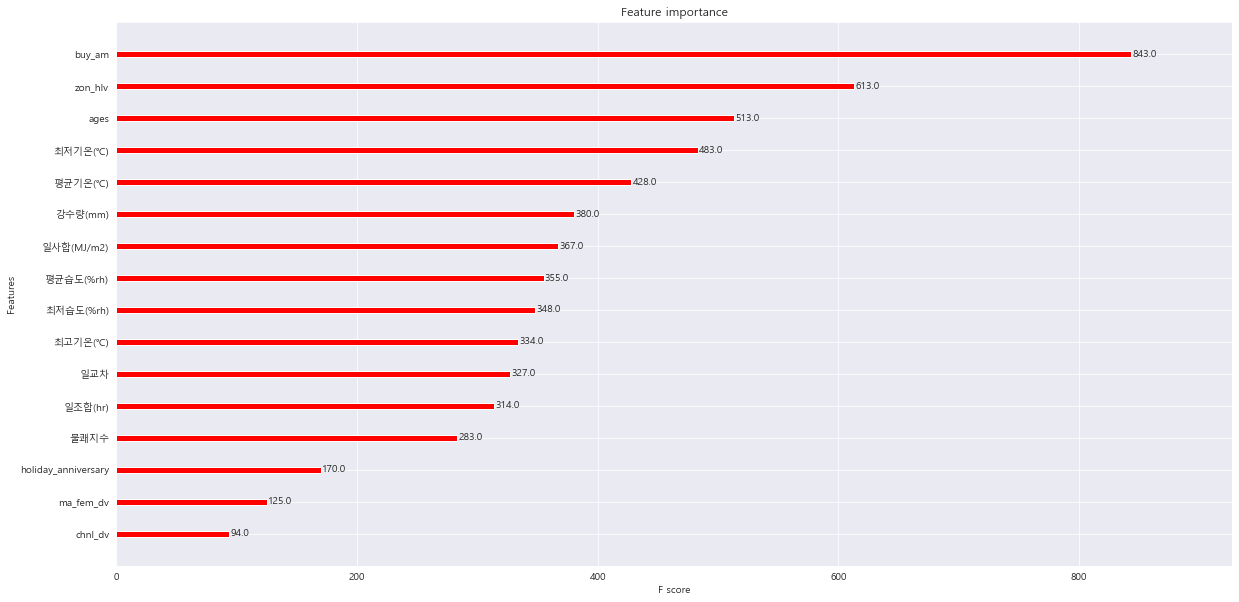

<Figure size 1440x1440 with 0 Axes>

In [193]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import *

matplotlib.rcParams['font.family'] ='Malgun Gothic'
plot_importance(model1, color = "red")
plt.figure(figsize=(20,20))
plt.show()


In [134]:
coptest1 = pd.DataFrame(coptest, columns = columns1)
coptest1.drop(columns = ['k_mean_cluster'], inplace =True)
lpaytest1 = pd.DataFrame(lpaytest, columns = columns1)
lpaytest1.drop(columns = ['k_mean_cluster'], inplace =True)

In [135]:
coptest['k_mean_cluster'] = model1.predict(coptest1)
lpaytest['k_mean_cluster'] = model1.predict(lpaytest1)

# 상품 추천 모델

In [137]:
dataset = data_clustering.drop(columns = 'clac_hlv_nm')
y_label = data_clustering['clac_hlv_nm']

In [138]:
columns2 = dataset.columns.tolist()
columns2

['ma_fem_dv',
 'ages',
 'zon_hlv',
 'chnl_dv',
 'buy_am',
 '강수량(mm)',
 '평균기온(℃)',
 '최저기온(℃)',
 '최고기온(℃)',
 '평균습도(%rh)',
 '최저습도(%rh)',
 '일조합(hr)',
 '일사합(MJ/m2)',
 '일교차',
 'holiday_anniversary',
 'k_mean_cluster',
 '불쾌지수']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_label, test_size=0.1, stratify = y_label)

# 최적의 파라미터 선정 후 재학습 진행

In [140]:
model2=XGBClassifier(booster='gbtree',
                    colsample_bylevel=0.9,
                    colsample_bytree=0.8,
                    gamma=0,
                    max_depth=8,
                    min_child_weight=3,
                    learning_rate=0.05,
                    n_estimators=50,
                    objective='multi:softprob',
                    random_state=2,
                    #verbose = True
                    )

In [141]:
model2.fit(X_train,y_train, eval_set=[(X_test,y_test)],
             eval_metric = ['mlogloss', 'auc'],
             early_stopping_rounds=10,verbose=True)

C:\Users\kimhongbum\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\kimhongbum\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:3.91554	validation_0-auc:0.77673
[1]	validation_0-mlogloss:3.81356	validation_0-auc:0.78658
[2]	validation_0-mlogloss:3.74363	validation_0-auc:0.79082
[3]	validation_0-mlogloss:3.66357	validation_0-auc:0.80456
[4]	validation_0-mlogloss:3.59574	validation_0-auc:0.80779
[5]	validation_0-mlogloss:3.53161	validation_0-auc:0.81063
[6]	validation_0-mlogloss:3.47654	validation_0-auc:0.81255
[7]	validation_0-mlogloss:3.42420	validation_0-auc:0.81414
[8]	validation_0-mlogloss:3.37610	validation_0-auc:0.81571
[9]	validation_0-mlogloss:3.33602	validation_0-auc:0.81682
[10]	validation_0-mlogloss:3.29722	validation_0-auc:0.81776
[11]	validation_0-mlogloss:3.26185	validation_0-auc:0.81856
[12]	validation_0-mlogloss:3.23139	validation_0-auc:0.81924
[13]	validation_0-mlogloss:3.19860	validation_0-auc:0.82018
[14]	validation_0-mlogloss:3.16752	validation_0-auc:0.82075
[15]	validation_0-mlogloss:3.14187	validation_0-auc:0.82127
[16]	validation_0-mlogloss:3.11728	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=2, reg_alpha=0, ...)

In [163]:
#모델 저장
filename = 'model2.model'
model2.save_model(filename)

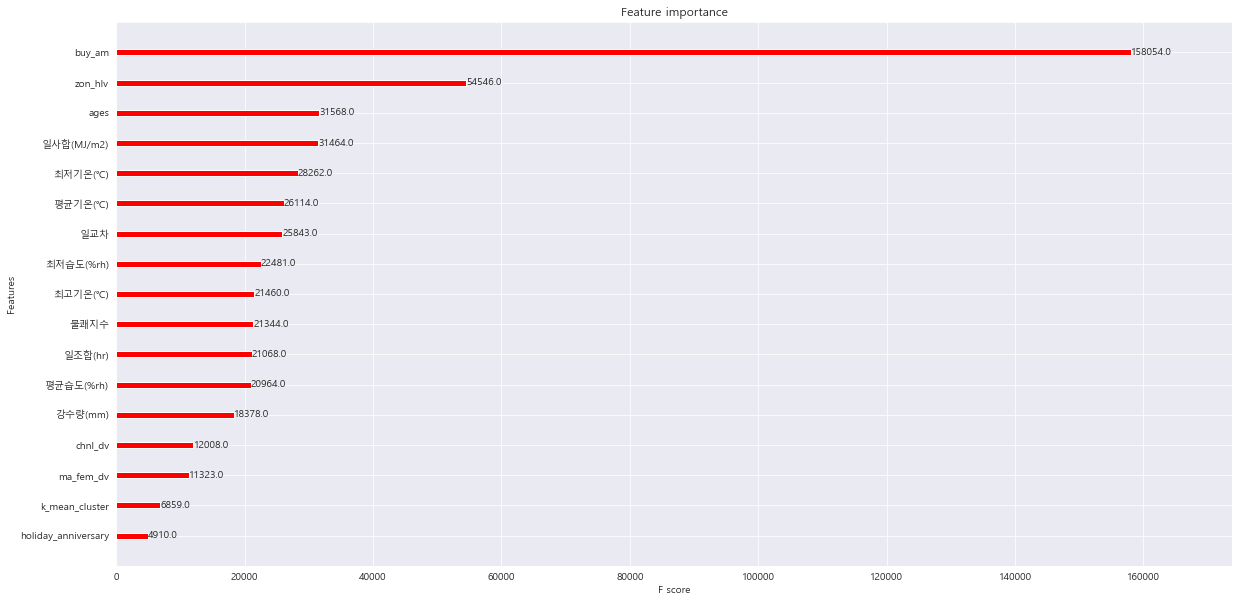

<Figure size 1440x1440 with 0 Axes>

In [194]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import *

matplotlib.rcParams['font.family'] ='Malgun Gothic'
plot_importance(model2, color = "red")
plt.figure(figsize=(20,20))
plt.show()


In [150]:
coptest2 = pd.DataFrame(coptest, columns = columns2)
#coptest1.drop(columns = ['k_mean_cluster'], inplace =True)
lpaytest2 = pd.DataFrame(lpaytest, columns = columns2)
#lpaytest1.drop(columns = ['k_mean_cluster'], inplace =True)

In [155]:
coptest['clac_hlv_nm'] = model2.predict(coptest2)
lpaytest['clac_hlv_nm'] = model2.predict(lpaytest2)

In [160]:
coptest['clac_hlv_nm'] = le2.inverse_transform(coptest['clac_hlv_nm'])
lpaytest['clac_hlv_nm'] = le2.inverse_transform(lpaytest['clac_hlv_nm'])

In [164]:
coptest.head(3)

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am,ma_fem_dv,ages,zon_hlv,zon_mcls,날짜,강수량(mm),평균기온(℃),최저기온(℃),최고기온(℃),평균습도(%rh),최저습도(%rh),일조합(hr),일사합(MJ/m2),year,month,요일,일교차,불쾌지수,holiday_anniversary,k_mean_cluster,clac_hlv_nm
0,M839993508,21102612B015763935,B01,B010012,1,2021-10-26,20211026,12,60000,0,5,16,Z17024,20211026,0.0,11.3,4.6,19.1,73.0,10.0,9.1,13.98,2021,10,1,14.5,53.18051,0,0,테넌트/음식점
1,M839993508,21110610B014219744,B01,B010012,1,2021-11-06,20211106,10,17100,0,5,16,Z17024,20211106,0.0,12.7,6.6,20.3,70.0,19.0,8.4,12.49,2021,11,5,13.7,55.37810,1,2,축산물
2,M839993508,21021112B013419710,B01,B010012,1,2021-02-11,20210211,12,136500,0,5,16,Z17024,20210211,0.0,4.4,-1.5,11.3,68.0,13.0,5.8,11.61,2021,2,3,12.8,43.10208,0,0,스포츠패션


In [166]:
coptest.to_csv("cop_latent1.csv", encoding = 'cp949')

In [161]:
lpaytest.to_csv("lpay_latent.csv", encoding = 'cp949', index = False)